# Introduction

This is a learning project that aims to build an elementary evolutionary neural network to play a simple game of survival. The main idea behind this work is to create a trainable neural network without backpropagation while relying only on random mutations.

IMPORTANT: Python version >= 3.11 is required.

# Game description

The game consists of an environment in the form of a wraparound square field and two types of cells: agents and food. The objective is simple: an agent must collect as many food cells as it can within the given time (in the image below, blue is agent, pink is food). 

![text](https://raw.githubusercontent.com/iliatarasov/simple-evolutionary-neural-network-with-numpy/main/data/agents/step%200.png)

Each agent is a single linear layer of neurons with an input size relative to the environment size, an output size of 4 and softmax activation.
```python
class Agent:
    def __init__(self, field_size: int=20, primarch: bool=False) -> None:
        if primarch:
            self.weights = np.random.randn(field_size ** 2, 4)
            self.biases = np.zeros(4)
        self.score = 0
        self.field_size = field_size
```

Given the field state as an input, this layer constructs a probability vector that describes the agent's desired direction of the next move. The vector is decoded by argmax into a scalar (0: left, 1: right, 2: down, 3: up). 

```python
class Agent:
        ...
        def forward(self, board: np.ndarray) -> int:
                value = np.matmul(board.flatten().T, self.weights) + self.biases
                softmax = np.exp(value) / (np.exp(value).sum() + 1e-6)
                return np.argmax(softmax)
```

Within one round the agent makes a move after seeing the board, then receives a score increment if successfull at obtaining the food, which is immediately replaced (meaning that multiple points can be acquired in one round). This loop continues until the time runs out:
```python
while time_remaining > 0:
    if not food_exists:
        #place a food on a random cell other than the agent's position

    board = #initialize the board
    action = agent.forward(board)

    match action:
        case 0:
            ...

    if agent.pos == food_pos:
        food_exists = False
        agent.score += 1

    time_remaining -= 1
```

If the agent fails to acquire any food at all, I thought it would be useful to still give it some score (it will accelerate initial evolution). That score is proportional to the shortest distance remaining to the food in the last round (in steps) and the ```fail_reward``` parameter.

A generation is a process of survival and selection, where the ones performing better get to reproduce. The following events occur in each generation:

1. All agents play for a set number of rounds and receive their total score:
```python 
    
    for agent in self.agents:
        scores.append(np.mean([play_round(agent, ...
```
2. The ones that will reproduce are determined based on performance:
```python

    reproducing_agents = sorted(zip(self.agents, scores), key=lambda x: x[1], 
                                reverse=True)[:n_reproducing]
```
3. Children are created via the specified reproduction method, then they receive a random mutaion and are added to the next generation of agents:
```python

    self.agents = []
    parent = iter(reproducing_agents)
    match reproduction_type:
        case 'sexual':
            for parent1, parent2 in zip(parent, parent):
                for _ in range(int(2 / reproducing_percentage)):
                    child = parent1[0].reproduce(parent2[0], 
                                                type='sexual')
                    child.mutate(mutation_rate=mutation_rate)
                    self.agents.append(child)
        case 'asexual':
            for parent0 in parent:
                for _ in range(int(1 / reproducing_percentage)):
                    child = parent0[0].reproduce(type='asexual')                        
                    child.mutate(mutation_rate=mutation_rate)
                    self.agents.append(child)
```

The mutation operation is just an addition of Gaussian noise to the 'genome':
```python
def mutate(self, mutation_rate: float=0.01) -> None:
    self.weights += np.random.randn(*self.weights.shape) * mutation_rate
    self.biases += np.random.randn(*self.biases.shape) * mutation_rate
```

# Network initialization and training

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from evo.network import Evo

Let us initialize a network of 100 agents in a 10x10 field:

In [2]:
n_agents = 100
field_size = 10
evo = Evo(n_agents, field_size)

The network will be trained for 20000 generations, each agent will play 10 rounds in its lifetime, mutation will be constant at a rate of ~10% of the primarch genes, 20% of agents will reproduce sexually paired best-to-second-best:

In [3]:
n_generations = 20000
rounds_per_agent = 10
mutation_type = 'constant' 
initial_mutation_rate = 0.1
pairing_type = 'best' 
reproducing_percentage = 0.2 
reproduction_type = 'sexual' 
output_path = 'data/results.pkl'

In [4]:
evo.train(n_generations=n_generations,
          rounds_per_agent=rounds_per_agent,
          mutation_type=mutation_type,
          initial_mutation_rate=initial_mutation_rate,
          reproducing_percentage=reproducing_percentage,
          reproduction_type=reproduction_type,
          pairing_type=pairing_type,
          output_path=output_path)

Generation 1000/20000	 high score: 9.6
Generation 2000/20000	 high score: 10.8
Generation 3000/20000	 high score: 10.8
Generation 4000/20000	 high score: 11.1
Generation 5000/20000	 high score: 11.6
Generation 6000/20000	 high score: 12.1
Generation 7000/20000	 high score: 12.1
Generation 8000/20000	 high score: 12.5
Generation 9000/20000	 high score: 12.8
Generation 10000/20000	 high score: 12.9
Generation 11000/20000	 high score: 12.9
Generation 12000/20000	 high score: 12.9
Generation 13000/20000	 high score: 13.35
Generation 14000/20000	 high score: 13.35
Generation 15000/20000	 high score: 13.35
Generation 16000/20000	 high score: 13.35
Generation 17000/20000	 high score: 13.35
Generation 18000/20000	 high score: 13.35
Generation 19000/20000	 high score: 13.35
Generation 20000/20000	 high score: 14.1


# Results

Import the data that we pickled:

In [4]:
with open(output_path, 'rb') as file:
    results = pickle.load(file)

Plot mean and high scores per generation:

Text(0.5, 1.0, 'Mean scores per generation')

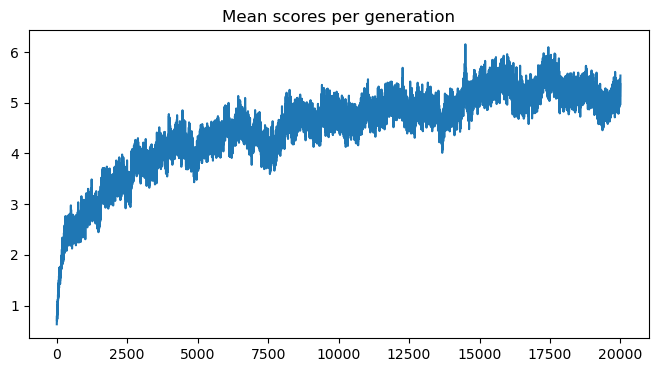

In [38]:
%matplotlib inline
plt.figure(figsize=(8, 4))
plt.plot(results['mean scores'])
plt.title(f'Mean scores per generation')

Text(0.5, 1.0, 'High scores per generation')

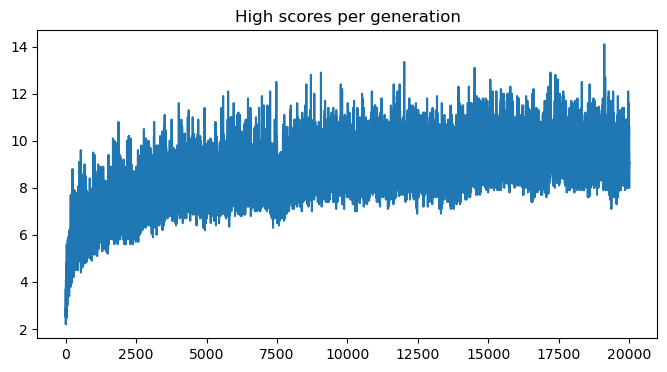

In [37]:
plt.figure(figsize=(8, 4))
plt.plot(results['high scores'])
plt.title(f'High scores per generation')

As you can see, mean and high scores per generation increase rapidly at first and then continue rising slowly. My understanding of this is that mutations are very favorable in the beginning as most of the agents will perfopm poorly, whereas closer to the end it is accumulated knowledge that is more important and with each generation an advancing mutation is less and less likely to appear. 

Let us now inspect the best agent and its score (remember, this score is over 10 rounds):

In [30]:
best_agent = results['best agents'][np.argmax(results['high scores'])]
print(best_agent.score)

21


Make the agent play a round and visualize it:

In [12]:
from evo.play import vizualize_round
vizualize_round(best_agent, path='data/agents/', time_limit=50)

5.0

I haven't found a good way to embed a gif into a jupyter notebook file for display on github, so here is a link instead: [GIF](https://raw.githubusercontent.com/iliatarasov/simple-evolutionary-neural-network-with-numpy/main/data/agents/animation.gif) (it is the same GIF as in README.md). I have noticed that over 20000 generations the agents have generally learned to move in a top-right to bottom-left diagonal direction. The agent displayed in the GIF does this while adjusting its position slightly to catch the food.

# Conclusion

The main goal of this project was to demonstrate a concept and I am satisfied with what I've been able to achieve. That said, there is still a number of things that could be done if I wanted to improve the quality of the resulting agents: 
1. Increase the complexity of the agents. My agents are only single-layer networks and this limits the amount of learning they can receive. By adding more linear layers with non-linear activations I assume I can increase their scores. 
2. Increase the number of training generations. While this can potentially make their scores higher, looking at the graphs of scores per generation my intuition is that this process is logarithmic so I wouldn't bet too much on this. 

Thanks for reading and please leave a star if you found this useful or interesting. 